In [2]:
!pip install numpy
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 1/'
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [5]:
import copy
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
from torchvision import transforms, datasets
import seaborn as sns
import torch.optim as optim
import torchvision.models.quantization as models
from torch.quantization import convert
from torch.utils.tensorboard import SummaryWriter

# Create writer for tensorboard
writer = SummaryWriter('runs/Quantized_Transfer_Learner')

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

#Create datasets in dictionary with for loop passing in dir names and adding transform to tensor and normalize
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),data_transforms[x])
                  for x in ['train', 'val', 'test']}
#Load datasets in same way shuffle and make batch size 4 this can be tuned, workers at 2 for colab
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
#Similar process read in dataset sizes for accuracy later on
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#Read in classes from train, could be any as long as all directories have all classes
class_names = image_datasets['train'].classes

#Change to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Check what device is being used as well as dataset sizes
print(device)
print(dataset_sizes)

cuda:0
{'train': 1287, 'val': 389, 'test': 412}


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  """
  Function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion loss function
    optimizer: Optimizer to use for training
    scheduler: Instance of torch.optim.lr_scheduler
    num_epochs: Number of epochs
    device: Device to run the training on, CUDA or CPU on colab.
  """
  #Time taken to train start
  since = time.time()

  #Copy current weights 
  best_model_wts = copy.deepcopy(model.state_dict())
  #Set accuracy
  best_acc = 0.0
  
  #For loop for training
  for epoch in range(num_epochs):
    #Printing epochs
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      #Set running loss and correct count
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        #Send to device for training
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      #Step each train
      if phase == 'train':
        scheduler.step()
      #Calculate loss and accuracy
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      #Print loss accuracy and phase
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #Send to tensorboard to be plotted
      if phase == 'train':
          writer.add_scalar('Training Loss', epoch_loss/1000, epoch * len(dataloaders['train']))
          writer.add_scalar('Training Accuracy', epoch_acc, epoch)
      else:
        writer.add_scalar('Validaiton Loss', epoch_loss/1000, epoch * len(dataloaders['val']))
        writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

      # deep copy the model when decent score
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  #When complete calc time taken
  time_elapsed = time.time() - since
  #Print time taken and validation accuracy 
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights and send back trained model
  model.load_state_dict(best_model_wts)
  return model

In [8]:
def create_combined_model(model_fe):
  # Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1, # Add rest of layers
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Create a new head
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 6), #Add in linear features and class num
  )

  # Combine above
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [9]:
#Call resnet18 model
model = models.resnet18(pretrained=True, progress=True, quantize=False)
#Set num of features
num_ftrs = model.fc.in_features
# Set model to train
model.train()
#Fuse model
model.fuse_model()
# Combine the model we have
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# prepare for quantization
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)
#for each param set requires_grad to false
for param in model_ft.parameters():
  param.requires_grad = True
#Set to device
model_ft.to(device) 
#Create loss function 
criterion = nn.CrossEntropyLoss()

#Create optimiser for model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

#Set scheduler, decay learning rate by a factor of 0.3 every 5 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


Epoch 0/24
----------
train Loss: 1.0851 Acc: 0.5866
val Loss: 0.4053 Acc: 0.8586

Epoch 1/24
----------
train Loss: 0.4931 Acc: 0.8298
val Loss: 0.5395 Acc: 0.8072

Epoch 2/24
----------
train Loss: 0.4267 Acc: 0.8772
val Loss: 0.2520 Acc: 0.9280

Epoch 3/24
----------
train Loss: 0.4768 Acc: 0.8765
val Loss: 0.2653 Acc: 0.9460

Epoch 4/24
----------
train Loss: 0.5557 Acc: 0.8563
val Loss: 0.7031 Acc: 0.7326

Epoch 5/24
----------
train Loss: 0.4711 Acc: 0.9138
val Loss: 0.1530 Acc: 0.9743

Epoch 6/24
----------
train Loss: 0.4159 Acc: 0.9456
val Loss: 0.1857 Acc: 0.9692

Epoch 7/24
----------
train Loss: 0.3864 Acc: 0.9557
val Loss: 0.3306 Acc: 0.9254

Epoch 8/24
----------
train Loss: 0.4085 Acc: 0.9580
val Loss: 0.1652 Acc: 0.9846

Epoch 9/24
----------
train Loss: 0.4144 Acc: 0.9650
val Loss: 0.2467 Acc: 0.9640

Epoch 10/24
----------
train Loss: 0.3828 Acc: 0.9814
val Loss: 0.1617 Acc: 0.9871

Epoch 11/24
----------
train Loss: 0.4034 Acc: 0.9798
val Loss: 0.1685 Acc: 0.9871

Ep

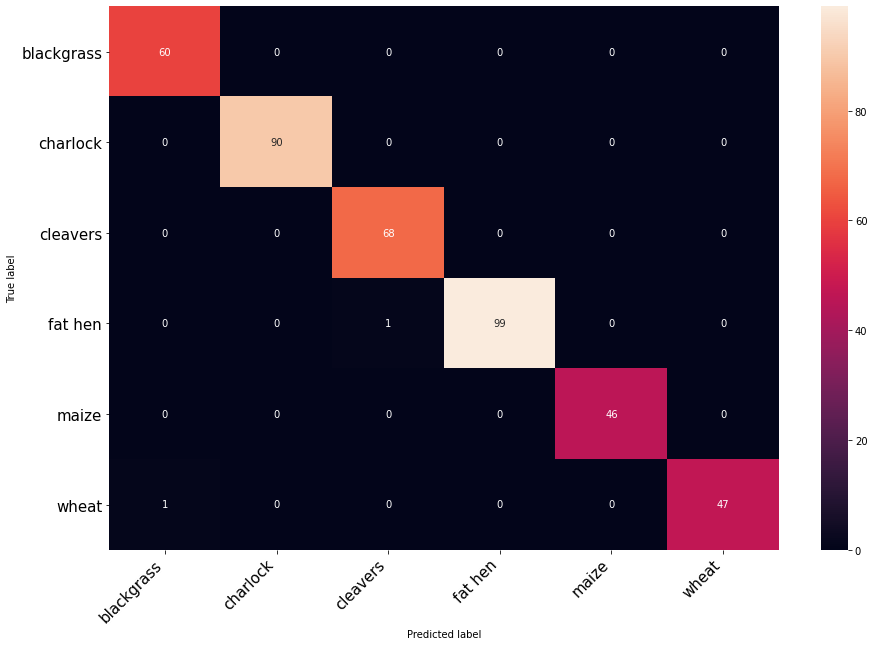

In [10]:
#Train model
model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=25, device=device)
#Set to CPU for quantization
model_ft_tuned.cpu()
#Quantize
model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

#Call test data
images, labels = next(iter(dataloaders['test']))
#Change to CPU for testing
device =  torch.device("cpu")
#Send to tensorboard
writer.add_graph(model_quantized_and_trained, images)

print("Testing model")
#Set confusion matric up as 6x6 (num of classes)
confusion_matrix = torch.zeros(6, 6)
#For loop for test and assigning to confusion matrix for multi class
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['test']):
        #Set images and labels to same device as model
        images = images.to(device)
        labels = labels.to(device)
        #Pass model image
        outputs = model_quantized_and_trained(images)
        #Compare model prediction with actual
        _, pred = torch.max(outputs, 1)
        #For loop to add to confusion matrix
        for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1

#Print matrix created
print(confusion_matrix)
#Find each class accuracy
accuracy_individ = confusion_matrix.diag()/confusion_matrix.sum(1)
#Print each class accuracy
print(accuracy_individ)

#Plot figure for easier understanding of model
plt.figure(figsize=(15,10))
#Set to dataframe for seaborn heatmap
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#Call heatmap with dataframe
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#Call heatmap with dataframe
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
#Save for later use
conf = root_path + "Conf_matrix_Quantized.png"
plt.savefig(conf)

In [11]:
#convert accuracies to numpy
accuracy_indi = accuracy_individ.numpy()
#Convert matrix to numpy
matrix = confusion_matrix.numpy()
#Total up each class verical from matrix
totals = np.sum(matrix, axis = 1)
#Total up each class horizontal from matrix
fp_total = np.sum(matrix, axis = 0)


overall_total = sum(totals)
#Evaluation metrics for loop
for i in range(6):
  total = totals[i]
  TP = total * accuracy_indi[i]
  FN = total - TP
  FP = fp_total[i] - TP
  TN = overall_total - TP
  Accuracy = (TP + TN)/ (TP + FP + TN + FN)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  F1 = (2*TP) / (2*TP + FP + FN)
  MCC = ((TP * TN) - (FP *FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) )
  Error_rate = (FP + FN)/ (TP + FP + TN + FN) 
  Sensitivity = TP / (TP +FN)
  GM = np.sqrt((TP*TN))
  F_M = (2*Precision * Recall) / (Precision + Recall)
  print(class_names[i].capitalize())
  print("True Positive value = " + str(TP))
  print("False Negative value = " + str(FN))
  print("False Positive value = " + str(FP))
  print("True Negative value = " + str(TN))
  print("Accuracy = " + str(Accuracy))
  print("Precision = " + str(Precision))
  print("Recall = " + str(Recall))
  print("Specificity = " + str(Specificity))
  print("F1 Score = " + str(F1))
  print("MCC = " + str(MCC))
  print("Error Rate = " + str(Error_rate))
  print("Sensitivity = " + str(Sensitivity))
  print("Geometric Mean = " + str(GM))
  print("F-Measure = " + str(F_M))
  print()
#Save the model for later use to be deployed using torchserve
s = torch.jit.script(model_quantized_and_trained)
torch.jit.save(s, root_path + 'transfer_learner.pt')

Blackgrass
True Positive value = 60.0
False Negative value = 0.0
False Positive value = 1.0
True Negative value = 352.0
Accuracy = 0.9975786924939467
Precision = 0.9836066
Recall = 1.0
Specificity = 0.9971671388101983
F1 Score = 0.9917355371900827
MCC = 0.99036363853618
Error Rate = 0.002421307506053269
Sensitivity = 1.0
Geometric Mean = 145.3272169966796
F-Measure = 0.9917355471235115

Charlock
True Positive value = 90.0
False Negative value = 0.0
False Positive value = 0.0
True Negative value = 322.0
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
Specificity = 1.0
F1 Score = 1.0
MCC = 1.0
Error Rate = 0.0
Sensitivity = 1.0
Geometric Mean = 170.23513150933329
F-Measure = 1.0

Cleavers
True Positive value = 68.0
False Negative value = 0.0
False Positive value = 1.0
True Negative value = 344.0
Accuracy = 0.9975786924939467
Precision = 0.98550725
Recall = 1.0
Specificity = 0.9971014492753624
F1 Score = 0.9927007299270073
MCC = 0.9912873970921302
Error Rate = 0.002421307506053269
Sensitivity

In [12]:
!tensorboard dev upload \
  --logdir  runs/Quantized_Transfer_Learner\
  --name "Quantized Resnet18 Transfer Learning Model" \
  --description "Relevant information on model found here" \
  --one_shot

2021-05-01 22:00:10.375091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Hk962W94SdKdMkF6mowh1g/

[2021-05-01T22:00:12] Started scanning logdir.
[2021-05-01T22:00:12] Total uploaded: 100 scalars, 0 tensors, 0 binary objects
[2021-05-01T22:00:12] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Hk962W94SdKdMkF6mowh1g/
